In [1]:
from IPython.display import display

from io import StringIO
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

from mosek.fusion import Model, Domain, Expr, ObjectiveSense


In [2]:
bid_df = pd.read_csv('20201007_bids_cb.csv')
offer_df = pd.read_csv('20201007_da_co.csv')


In [13]:
bid_df['Region'].unique()

array(['North', 'Central', nan, 'South'], dtype=object)

In [3]:
nodes = ['B1', 'B2', 'B3']
nnodes = len(nodes)

In [4]:
supply = pd.DataFrame([
    ['G1', 'B1', 100., 12.],
    ['G2', 'B2', 80., 20.],
], columns=['id', 'node', 'capacity (MWh)', 'offer ($/MWh)']).set_index('id')
nsupply = len(supply)
assert supply.node.isin(nodes).all()
supply

,node,capacity (MWh),offer ($/MWh)
id,,,
G1,B1,100.0,12.0
G2,B2,80.0,20.0


In [5]:
demand = pd.DataFrame([
    ['D1', 'B2', 100., 40.],
    ['D2', 'B3', 50., 35.],
], columns=['id', 'node', 'demand (MWh)', 'bid ($/MWh)']).set_index('id')
ndemand = len(demand)
assert demand.node.isin(nodes).all()
demand

,node,demand (MWh),bid ($/MWh)
id,,,
D1,B2,100.0,40.0
D2,B3,50.0,35.0


In [6]:
lines = pd.DataFrame([
    ['L12', 'B1', 'B2', 40., 500.],
    ['L13', 'B1', 'B3', 100., 500.],
    ['L23', 'B2', 'B3', 100., 500.],
], columns=['id', 'source', 'dest', 'capacity (MWh)', 'susceptance (S)']).set_index('id')
nlines = len(lines)
lines

,source,dest,capacity (MWh),susceptance (S)
id,,,,
L12,B1,B2,40.0,500.0
L13,B1,B3,100.0,500.0
L23,B2,B3,100.0,500.0


In [7]:
M = Model('power')
log = StringIO()
M.setLogHandler(log)
theta = M.variable('theta', nnodes, Domain.inRange(
    [0.] + [-np.pi] * (nnodes - 1), 
    [0.] + [np.pi] * (nnodes - 1), 
))
pD = M.variable('pD', ndemand, Domain.inRange(0, demand['demand (MWh)'].values))
pG = M.variable('pG', nsupply, Domain.inRange(0, supply['capacity (MWh)'].values))
lambdaD = demand['bid ($/MWh)'].values
lambdaG = supply['offer ($/MWh)'].values

line_constraints = Domain.inRange(-lines['capacity (MWh)'].values, 
                                  lines['capacity (MWh)'].values)
line_flows = M.variable('flows', nlines, line_constraints)
src_idx = [nodes.index(x) for x in lines.source]
dst_idx = [nodes.index(x) for x in lines.dest]
phase_diff = Expr.sub(theta.pick(src_idx), theta.pick(dst_idx))
phase_flow = M.constraint(Expr.sub(line_flows, 
                                  Expr.mulElm(lines['susceptance (S)'].values, phase_diff)),
                         Domain.equalsTo(0.))
node_balance_eqs = []
for node in nodes:
    supply_idx = np.flatnonzero(supply.node == node).astype('int32')
    node_supply = Expr.sum(pD.pick(supply_idx))
    demand_idx = np.flatnonzero(demand.node == node).astype('int32')
    node_demand = Expr.sum(pG.pick(demand_idx))
    balance = Expr.sub(node_supply, node_demand)
    direction = [-1 if line.source == node else 
                 1 if line.dest == node else 
                 0 for line_idx, line in lines.iterrows()]
    balance = Expr.add(balance, Expr.dot(direction, line_flows))
    balance_eq = M.constraint(node + 'balance', balance, Domain.equalsTo(0.))
    node_balance_eqs.append(balance_eq)

obj = Expr.sub(Expr.dot(lambdaD, pD), Expr.dot(lambdaG, pG))
M.objective('obj', ObjectiveSense.Maximize, obj)
M.solve()

demand['consumed (MWh)'] = pD.level()
supply['supplied (MWh)'] = pG.level()
lines['flow (MWh)'] = line_flows.level()
buses = pd.DataFrame({
    'volt. angle (rad)': theta.level(),
    'node price ($/MWh)': [e.dual()[0] for e in node_balance_eqs]
}, index=nodes)

In [8]:
display(demand)
display(supply)
print('Energy scheduled: {:g}'.format(demand['consumed (MWh)'].sum()))
print('Objective value: {:g}'.format(M.primalObjValue()))
display(lines)
display(buses)

,node,demand (MWh),bid ($/MWh),consumed (MWh)
id,,,,
D1,B2,100.0,40.0,100.0
D2,B3,50.0,35.0,50.0


,node,capacity (MWh),offer ($/MWh),supplied (MWh)
id,,,,
G1,B1,100.0,12.0,70.0
G2,B2,80.0,20.0,80.0


Energy scheduled: 150
Objective value: 3310


,source,dest,capacity (MWh),susceptance (S),flow (MWh)
id,,,,,
L12,B1,B2,40.0,500.0,40.0
L13,B1,B3,100.0,500.0,60.0
L23,B2,B3,100.0,500.0,20.0


,volt. angle (rad),node price ($/MWh)
B1,0.00,40.0
B2,-0.08,12.0
B3,-0.12,26.0


In [9]:
print(log.getvalue())

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(3) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(4) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(5) of matrix 'A'.
Problem
  Name                   : power           
  Objective sense        : max             
  Type                   : LO (linear optimization problem)
  Constraints            : 6               
  Cones                  : 0               
  Scalar variables       : 11              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 3
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 1
Eliminator terminated.
Eliminator - tries                  : 2                 time             

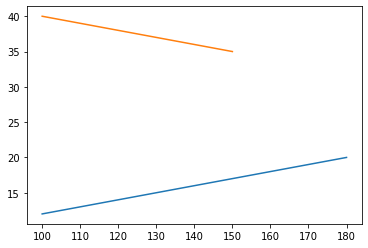

In [10]:
plt.plot(supply['capacity (MWh)'].cumsum(), supply['offer ($/MWh)'])
plt.plot(demand['demand (MWh)'].sort_index(ascending=True).cumsum().sort_index(),
         demand['bid ($/MWh)']
        )